# Abstract
    Penelitian ini bertujuan untuk melakukan analisis sentimen terhadap ulasan pengguna aplikasi GoPay yang diperoleh dari platform Google Play Store, dengan total data awal sebanyak 148.500 entri. Proses analisis mencakup tahap pra-pemrosesan data teks, pelabelan sentimen menggunakan pendekatan berbasis skor dan leksikon, eksplorasi data (EDA), serta pembangunan model klasifikasi sentimen menggunakan algoritma machine learning tradisional (Naive Bayes, Logistic Regression, Support Vector Machine) dan pendekatan deep learning (Long Short-Term Memory/LSTM).

    Karena keterbatasan waktu dan sumber daya komputasi, jumlah data dianalisis dibatasi menjadi 15.000 entri ulasan terbaru. Proses pra-pemrosesan teks meliputi pembersihan karakter khusus, normalisasi kata tidak baku (slang), tokenisasi, penghapusan kata umum (stopword), serta stemming menggunakan library Sastrawi. Data diklasifikasikan ke dalam tiga kategori sentimen, yaitu positif, negatif, dan netral, dengan sentimen terbanyak adalah positif. tetapi berdasarkan proses analisis lebih lanjut didapati bahwa sebagian besar ulasan yang termasuk kategori netral cenderung memiliki kecenderungan sentimen negatif tersembunyi.

    Evaluasi performa model menunjukkan bahwa algoritma Naive Bayes dengan fitur TF-IDF menghasilkan akurasi pengujian tertinggi sebesar 85,27%, diikuti oleh SVM (85,20%), Logistic Regression (85,13%), dan LSTM (84,59%). Hasil ini menunjukkan bahwa model tradisional berbasis statistik masih mampu memberikan performa yang kompetitif. Namun, terdapat potensi peningkatan performa dengan eksplorasi model bahasa yang lebih canggih seperti IndoBERT serta optimalisasi tahap pra-pemrosesan data.

# Table Of Content : 
1. Import library
2. Import Data
3. Text preprocessing
4. Labelling
5. EDA & Visualization
6. Modelling & Training data
7. Model Evaluation
8. Conclusion

# Import Library

In [1]:
# !pip install sastrawi
# !pip install nltk

In [2]:
# Data Manipilation & EDA
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np
import swifter
import time


# Data Visualization & EDA
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from collections import Counter
import plotly.express as px


# Text Processing
import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks
import nltk
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

#Lexicon Labelling
import csv
import requests
from io import StringIO

#Visualization Text
from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

#Modelling & Evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tugas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tugas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data

In [3]:
df = pd.read_csv('Dataset\Gopay_ScrappingData.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148500 entries, 0 to 148499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              148500 non-null  object
 1   userName              148500 non-null  object
 2   userImage             148500 non-null  object
 3   content               148499 non-null  object
 4   score                 148500 non-null  int64 
 5   thumbsUpCount         148500 non-null  int64 
 6   reviewCreatedVersion  131677 non-null  object
 7   at                    148500 non-null  object
 8   replyContent          30203 non-null   object
 9   repliedAt             30203 non-null   object
 10  appVersion            131677 non-null  object
dtypes: int64(2), object(9)
memory usage: 12.5+ MB


**Profile Dataset**

Dataset ini berasal dari hasil scraping ulasan aplikasi GoPay di Google Play Store menggunakan kode yang telah saya buat. Data yang dihasilkan mencakup 148.500 entri ulasan dengan 11 kolom yang berisi berbagai informasi terkait pengalaman pengguna.  

Setiap ulasan memiliki **reviewId** (ID unik ulasan), **userName** (nama pengguna), **userImage** (foto profil pengguna), **content** (isi ulasan), **score** (rating bintang), dan **thumbsUpCount** (jumlah like pada ulasan) yang lengkap. Selain itu, kolom **at** (waktu ulasan dibuat) juga tersedia untuk semua entri. Namun, beberapa kolom memiliki data yang tidak lengkap, seperti **reviewCreatedVersion** (versi aplikasi saat ulasan dibuat) dan **appVersion**, yang hanya tersedia pada sekitar 88,7% ulasan (131.677 entri).  

Selain itu, hanya 30.203 ulasan (sekitar 20%) yang mendapat balasan dari pihak pengembang, ditunjukkan oleh kolom **replyContent** (balasan dari pengembang) dan **repliedAt** (waktu balasan). Hal ini menunjukkan bahwa sebagian besar ulasan tidak mendapatkan tanggapan resmi dari pihak aplikasi.  

Data ini dapat digunakan untuk berbagai analisis, termasuk analisis sentimen, pemahaman kepuasan pengguna, serta evaluasi respons pengembang terhadap masukan pelanggan.

In [5]:
df.sample(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
52376,70fcdb44-7084-4680-80b7-07f3bc1bd02d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Pelayanan cepat dan responsif,5,0,1.20.2,2024-04-30 22:07:12,NaN,NaN,1.20.2
95601,517203a3-c742-43a8-a0c6-5dbe79fbc2cf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat berguna,5,0,1.13.0,2023-12-07 16:12:05,NaN,NaN,1.13.0
134702,2c576b6d-996e-4621-9f15-251959e51354,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Info Akun.,1,0,1.23.0,2024-06-13 22:51:05,NaN,NaN,1.23.0
4536,a6f3fb64-4d1e-478c-9ba7-32836be8f7bd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolong dong login nya pake sidikjari/pin, biar...",4,0,NaN,2024-09-28 16:29:58,NaN,NaN,NaN
138424,3107f9b0-608b-457a-9400-1ebca8fb1fa7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Oke top,5,1,1.22.0,2024-06-09 04:47:57,NaN,NaN,1.22.0
145135,1176433c-951b-4464-ad95-12e1f8d87d7b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,nice hopefully ahead of her next nicer,5,0,1.19.0,2024-05-04 04:47:43,NaN,NaN,1.19.0
113953,e692fd24-5d76-44ea-b741-f6654a77eede,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Mantappp,5,0,1.37.1,2024-12-04 21:11:50,NaN,NaN,1.37.1
20144,d25d968e-b4d8-4b30-bbbc-6e06c5a489b7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Gara2 pernah hilang hp nya, terus tlp call cen...",1,1,1.5.1,2023-08-13 14:23:09,"Hai Deni Saputra, mohon maaf untuk kendala yan...",2023-08-13 14:34:55,1.5.1
126662,ff6063b8-a61e-4df2-8172-2c89fa1c4043,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ok mantap,5,0,1.29.1,2024-09-08 08:49:40,NaN,NaN,1.29.1
1648,49765edb-dee1-494a-a720-7e1881e3dffd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ini kenapa setelah di upgrade kok kembali ke g...,5,0,1.42.0,2025-02-22 11:01:22,NaN,NaN,1.42.0


# Text Preprocessing
Text preprocessing terdiri dari beberapa tahapan : 

**1. clean_text(text)** → Membersihkan teks dari mention, hashtag, RT, link, angka, dan karakter non-alfanumerik.

**2. fix_slangwords(text)** → Merubah kata-kata tidak baku/gaul menjadi baku

**3. tokenize_text(text)** → Memecah teks menjadi daftar kata (token).

**4. remove_stopwords(tokens)** → Menghapus kata-kata umum (stopwords) yang tidak relevan.

**5. stem_text(tokens)** → Mengubah kata menjadi bentuk dasar (stemming).

**6. to_sentence(tokens)** → Menggabungkan kembali daftar kata menjadi kalimat yang bersih.


In [6]:
# Inisiasi Steammer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Inisiasi Stopwords
stop_words = set(stopwords.words('indonesian')).union(stopwords.words('english'))

def clean_text(text):
    """Membersihkan teks dari karakter yang tidak perlu dan melakukan case folding."""
    text = text.lower()  # Case folding: Mengubah teks menjadi huruf kecil
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention (@username)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag (#hashtag)
    text = re.sub(r'RT[\s]', '', text)  # Menghapus retweet (RT)
    text = re.sub(r"http\S+", '', text)  # Menghapus link URL
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter selain huruf dan angka
    text = text.strip()  # Menghapus spasi di awal dan akhir teks
    return text

slangwords = {
    "gak": "tidak", "ga": "tidak", "tdk": "tidak", "bgt": "banget", "dgn": "dengan",
    "trs": "terus", "krn": "karena", "udh": "sudah", "sm": "sama", "jg": "juga",
    "tp": "tapi", "bkn": "bukan", "hrs": "harus", "dlm": "dalam", "bgt": "banget",
    "cmn": "cuma", "dpt": "dapat", "sy": "saya", "lg": "lagi", "sblm": "sebelum",
    "skt": "sakit", "ny": "nya", "smpe": "sampai", "bru": "baru", "bs": "bisa",
    "bsa": "bisa", "dpt": "dapat", "tdk": "tidak", "kl": "kalau", "sgt": "sangat", "bug" : "eror",
    "gua" : "saya", "gw" : "saya", "w" : "saya", "anjing" : "sial", "lu" : "kamu", "loe" : "kamu",
    "kcw" : "kecewa", "hr" : "hari", "k" : "aku", "fix" : "perbaiki", "bug" : "eror", "moga" : "semoga"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

def tokenize_text(text):
    """Memecah teks menjadi token (kata-kata)."""
    return word_tokenize(text)

def remove_stopwords(tokens):
    """Menghapus stopwords dalam bahasa Indonesia dan Inggris."""
    return [word for word in tokens if word not in stop_words]

def stem_text(tokens):
    """Melakukan stemming pada kata-kata dalam teks menggunakan Sastrawi."""
    return [stemmer.stem(word) for word in tokens]

def preprocess_text(text):
    """Melakukan preprocessing lengkap dari pembersihan hingga stemming."""
    text = clean_text(text)
    text = fix_slangwords(text)
    tokens = tokenize_text(text)
    filtered_tokens = remove_stopwords(tokens)
    stemmed_tokens = stem_text(filtered_tokens)
    return ' '.join(stemmed_tokens)  # Mengembalikan hasil sebagai teks kembali

**Test Hasil Preprocessing**

1. Ambil sample ulasan yang lebih dari 10 kata

In [7]:
df_filtered = df[df['content'].str.split().str.len() > 10]
df_filtered

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c4cca5b0-5af1-448c-b4d9-9d1535f1199a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sumpah gua kecewa banget sama gopay, gua udah ...",1,57,1.44.0,2025-04-02 21:49:44,"Hai Kak Rizki, mohon maaf atas ketidaknyamanan...",2025-04-03 08:59:58,1.44.0
1,bced8fec-24dd-4063-86f0-10cbf215f9fd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"parah banget ini saya kena scam voucher promo,...",1,25,1.45.0,2025-04-01 17:47:13,"Hai Kak Anis, mohon maat atas ketidaknyamanann...",2025-04-01 18:17:48,1.45.0
2,d9b8cd83-50ba-4ad5-855e-5d97a3d2cbd1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Di era digitalisasi sekarang ini,semua kebutuh...",5,19,1.44.0,2025-04-02 20:06:58,NaN,NaN,1.44.0
3,36a9994c-98e5-4427-84a5-d23484698d3b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"saya top up gopay, walau nominal kecil tapi ti...",1,7,1.44.0,2025-04-02 22:43:33,"Hai Kak Fathul, mohon maaf atas ketidaknyamana...",2025-04-03 12:14:47,1.44.0
4,5e295fec-8e3b-4084-bceb-9289f0c6e2b9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",1,340,1.44.0,2025-03-31 15:40:12,"Hai Kak Charis, pastikan nomor tujuan sudah be...",2025-03-31 16:25:18,1.44.0
...,...,...,...,...,...,...,...,...,...,...,...
145084,8e9a7666-35ba-4401-9d2a-5ce398227421,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Gopay sangat membantu untuk bertransaksi segal...,5,0,1.19.0,2024-04-19 21:20:57,NaN,NaN,1.19.0
145121,c77dd4fe-448a-42e4-bc73-509043774ad4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Di gunakan dengan mudah dan enk juga buat pemb...,5,4,1.19.0,2024-04-02 15:10:45,NaN,NaN,1.19.0
145157,90b6a8cb-86f3-4409-8bd7-1085e98e4127,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Implikasi ini aman terpercaya tapi belum digun...,5,0,1.19.0,2024-03-29 06:54:00,NaN,NaN,1.19.0
145188,8f3886e4-1b03-48ac-abc1-dc616bb91c19,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi ini cukup baik untuk transaksi ke mna...,5,3,1.19.0,2024-04-04 01:18:03,NaN,NaN,1.19.0


2. Contoh Penggunaan Text Preprocessing

In [8]:
# Contoh penggunaan 1
sample_text = "sumpah gua kecewa banget sama gopay, gua udah top up dari Livin, saldo udah kepotong, di riwayat gopay nya udah masuk tapi saldo nya belum berubah. segera ya! ini penting banget! masa masalah sepele gitu masih terjadi?"
processed_text = preprocess_text(sample_text)
print(processed_text)

sumpah kecewa banget gopay udah top livin saldo udah potong riwayat gopay nya udah masuk saldo nya ubah ya banget sepele gitu


In [9]:
# Contoh penggunaan 2
df_filtered_sample = df_filtered['content'].sample(50) 
pd.set_option('display.max_colwidth', None)  # Menampilkan seluruh teks tanpa batasan

start = time.time()
processed_text = df_filtered_sample.swifter.apply(preprocess_text)
print(processed_text)
end = time.time()
print(f"Processed in {end - start:.4f} seconds")  # Cek waktu proses tiap baris


Pandas Apply:   0%|          | 0/50 [00:00<?, ?it/s]

8174                                                                                                                                                                            mantap pokok butuh dadak bantu proses cepat
1496                                                                                                                                                 daftar pake nomor langsung pingmna masukin pinpinnya aja blum aplikasi
23714                                                                                              tambahin fitur bonus transfer bank e wallet kirim gopay e wallet tambah pajak nya kecuali bank terimakasih tolong update
16623                                                                                                                                                                     ngisi data tolak sulit transfer lo pinjam x tolak
9783                                                                                       tranfer mbanking gopay notif 

**Apply Function preprocess_text ke content/ulasan pengguna**

![WhatsApp Image 2025-04-05 at 06.38.08_002b5580.jpg](<attachment:WhatsApp Image 2025-04-05 at 06.38.08_002b5580.jpg>)
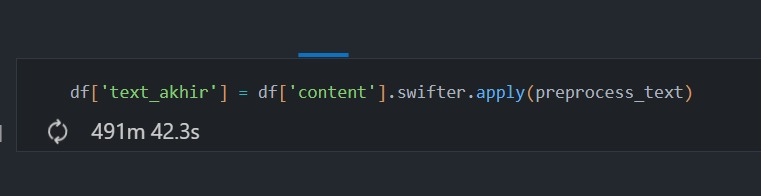

karena preprocess sebelumnya menggunakan 140rb sekian data, jadi prosesnya sangat lama dan akhirnya saya batalkan. oleh karena itu kita akan menggunakan 15ribu data saja sesuai dengan requirment dicoding, supaya prosesnya tidak memakan waktu. dan pada percobaan kedua kita akan menggunakan library swifter untuk mempecepat fungsi apply().


**Mengambil 15.000 data terkini**

In [10]:
df["at"] = pd.to_datetime(df["at"])
df = df.sort_values(by="at", ascending=True)
df_latest10k = df.tail(15000)
df = df_latest10k

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 14677 to 103584
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              15000 non-null  object        
 1   userName              15000 non-null  object        
 2   userImage             15000 non-null  object        
 3   content               15000 non-null  object        
 4   score                 15000 non-null  int64         
 5   thumbsUpCount         15000 non-null  int64         
 6   reviewCreatedVersion  12404 non-null  object        
 7   at                    15000 non-null  datetime64[ns]
 8   replyContent          5576 non-null   object        
 9   repliedAt             5576 non-null   object        
 10  appVersion            12404 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 1.4+ MB


**Run Jika Ingin melakukan Steamming**

In [ ]:
start = time.time()
df['text_akhir'] = df['content'].swifter.apply(preprocess_text)
end = time.time()
print(f"Processed in {end - start:.4f} seconds") 

In [ ]:
# Simpan supaya tidak melakukan preprocessing ulang
df.to_csv('Dataset/Gopay_Cleaned.csv', index= False)

**Run Jika Steamming Terlalau lama**

In [12]:
# Update Dataset
df = pd.read_csv('Dataset/Gopay_Cleaned.csv') #-> RUN INI JIKA STEAMMING LAMA

**Drop data yang kosong setelah preprocessing**

In [13]:
df = df.dropna(subset=['text_akhir'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14626 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              14626 non-null  object
 1   userName              14626 non-null  object
 2   userImage             14626 non-null  object
 3   content               14626 non-null  object
 4   score                 14626 non-null  int64 
 5   thumbsUpCount         14626 non-null  int64 
 6   reviewCreatedVersion  12033 non-null  object
 7   at                    14626 non-null  object
 8   replyContent          5572 non-null   object
 9   repliedAt             5572 non-null   object
 10  appVersion            12033 non-null  object
 11  text_akhir            14626 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


## Kesimpulan Text Preprocessing

Setelah dilakukan proses text preprocessing, terdapat beberapa teks akhir yang menjadi kosong atau null. Hal ini kemungkinan terjadi karena semua kata dalam teks tersebut dihapus akibat proses filtering (seperti stopwords removal, simbol, dan lainnya).

Untuk menghindari error dan meningkatkan performa model klasifikasi, maka data yang kosong perlu dihapus dari dataset. Dengan begitu, model bisa lebih fokus pada data yang valid dan bermakna saat melakukan training dan prediksi.

# Labelling

Pada proses labelling, kita akan menggunakan 2 cara labelling

1. menggunakan score untuk labelling
2. menggunakan lexicon dicoding untuk labelling

**1. Labelling Score**

In [15]:
def score_sentiment(score):
    """Memberikan label Sentiment berdasarkan score dari ulasan yang diberikan."""
    if score <= 2 :
        return 'Negatif'
    if score == 3 :
        return 'Neutral'
    else:
        return 'Positive'

df['score_sentiment'] = df['score'].apply(score_sentiment)

In [16]:
df['score_sentiment'].value_counts()

score_sentiment
Positive    8813
Negatif     5075
Neutral      738
Name: count, dtype: int64

In [17]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")


def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score -= lexicon_negative[word]

    # Menentukan polaritas
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity


In [18]:
tokenize = df['text_akhir'].apply(tokenize_text)
results = tokenize.apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['sentiment_lexicon_score'] = results[0]
df['lexicon_sentiment'] = results[1]
print(df['lexicon_sentiment'].value_counts())

lexicon_sentiment
positive    13242
neutral      1384
Name: count, dtype: int64


In [19]:
df.sample(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_akhir,score_sentiment,sentiment_lexicon_score,lexicon_sentiment
13435,ab522be7-842f-4917-a119-29ac876b3a6d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Mempermudah transaksi pembelian, pembayaran, atau pun transfer secara online. Thx Gopay...",5,0,NaN,2025-03-29 09:35:46,NaN,NaN,NaN,mudah transaksi beli bayar transfer online thx gopay,Positive,18,positive
11937,b8af0af9-ddf5-4013-a3be-56479896b43e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,mantap,5,0,1.43.0,2025-03-23 14:44:57,NaN,NaN,1.43.0,mantap,Positive,5,positive
9413,41dbe1bb-bbed-41d5-a844-d8cd91c2d916,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Haha.. ketipu aku, gratis TF padahal ada admin Rp.2500. sajubo, ternyata gratisnya kemana aja sesama gopay, bukan kebank lain.😁😁😤 Padahal baru transfer ke 2 kalinya. Ngadi2 emang.",1,0,1.43.0,2025-03-14 10:19:10,"Hai Kak Alex, mohon maaf atas ketidaknyamanannya. Saat ini transfer ke bank/e-wallet lain gratis 5x setiap bulan yang diperbaharui di awal bulan. Gratis biaya transfer akan langsung muncul pada saat kamu melakukan transfer. Jika kuota kamu sudah habis, maka kamu perlu membayar biaya transfer sesuai yang tercantum di aplikasi. ^Maura",2025-03-14 08:46:57,1.43.0,haha tipu gratis tf admin rp sajubo gratis mana aja gopay bank transfer kali ngadi emang,Negatif,9,positive
1489,85a9d4e1-a37e-4ec6-9b1d-9007f0c269a0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Mantapp,5,0,1.40.1,2025-02-10 14:56:49,NaN,NaN,1.40.1,mantapp,Positive,0,neutral
7709,3cdb38ba-21fb-4051-a938-55486532287b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Katanya cashback 100% uang kembali nyatanya gak kembali ..... Dasar,1,0,NaN,2025-03-06 17:02:27,"Hai Kak Fauzan, mohon maaf atas ketidaknyamanannya. Mengenai promo mengikuti syarat dan ketentuan yang berlaku. Apabila kamu mengalami kendala, silakan laporkan melalui menu Bantuan di aplikasi GoPay agar tim kami bisa bantu cek ya. Kami tunggu detail permasalahannya. ^Melisa",2025-03-06 17:15:26,NaN,cashback uang dasar,Negatif,0,neutral


## Kesimpulan Labelling
Karena requirement dari Dicoding mengharuskan minimal tiga sentimen yang berbeda, kita akan menggunakan hasil sentimen/labelling berdasarkan skor yang sudah kita buat sebelumnya.

Hal ini dilakukan karena labelling dari lexicon kurang baik dan hanya menghasilkan dua kelas saja, yaitu positif dan netral. Untuk memenuhi syarat, kita akan menyesuaikan metode labelling agar bisa mencakup tiga kelas sentimen.

In [20]:
# Menghapus Hasil labelling dari Lexicon
df = df.iloc[:, 0:13]

In [21]:
# Cek Data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14626 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              14626 non-null  object
 1   userName              14626 non-null  object
 2   userImage             14626 non-null  object
 3   content               14626 non-null  object
 4   score                 14626 non-null  int64 
 5   thumbsUpCount         14626 non-null  int64 
 6   reviewCreatedVersion  12033 non-null  object
 7   at                    14626 non-null  object
 8   replyContent          5572 non-null   object
 9   repliedAt             5572 non-null   object
 10  appVersion            12033 non-null  object
 11  text_akhir            14626 non-null  object
 12  score_sentiment       14626 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.6+ MB


# EDA & Visualization

**0. Membuat Kolom text_token untuk Analisis Kata Kata yang Sering Muncul**

In [22]:
# Tokenize hasil text_clean (kalau belum dalam bentuk list kata)
df['text_token'] = df['text_akhir'].swifter.apply(tokenize_text)

Pandas Apply:   0%|          | 0/14626 [00:00<?, ?it/s]

## Distribusi Sentiment

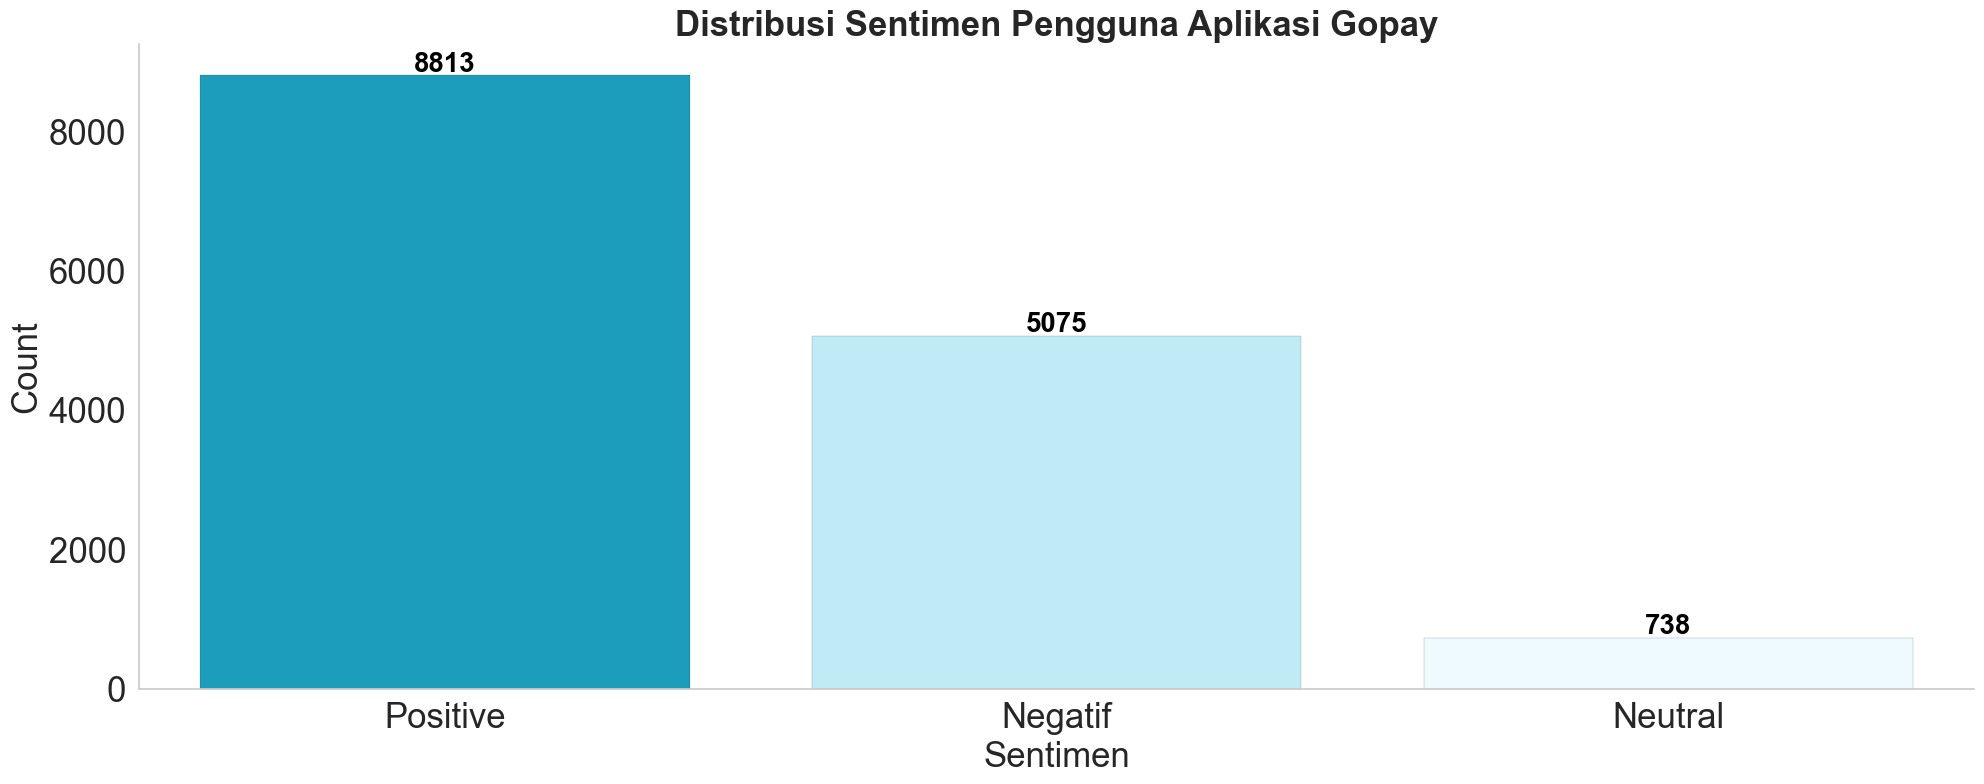

In [24]:
## Distribusi Sentiment
# Setting gaya seaborn
sns.set(style="whitegrid")

# Warna-warna custom biar lebih menarik (gradient style)
custom_palette = ['#02aed6', '#b6f1ff', '#ecfbff']  # positif, netral, negatif

plt.figure(figsize=(20, 8))
ax = sns.countplot(
    data=df,
    x='score_sentiment',
    palette=custom_palette,
    edgecolor='black',  # Buat efek garis di bar
    linewidth=0.1
)
ax.yaxis.grid(False)
# Tambahkan label angka di atas tiap bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 50,  # Biar agak ngambang di atas bar
        f'{int(height)}',
        ha='center',
        fontsize=20,
        weight='bold',
        color='black'
    )

# Judul dan label dengan style keren
plt.title('Distribusi Sentimen Pengguna Aplikasi Gopay', fontsize=25, weight='bold')
plt.xlabel('Sentimen', fontsize=25)
plt.ylabel('Count', fontsize=25)

# Rotate label jika perlu
plt.xticks(rotation=0, fontsize=25)
plt.yticks(fontsize=25)

# Hapus garis frame di atas dan kanan biar clean
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()


## Kata Umum dalam Data

In [25]:
# Ambil semua token dari seluruh data
all_words = Counter([item for sublist in df['text_token'] for item in sublist])

# Ambil 20 kata paling sering
top_all = pd.DataFrame(all_words.most_common(20), columns=['Common_words', 'count'])

# Tampilkan dengan gradasi warna
top_all.style.background_gradient(cmap='Blues')  # Bisa diganti cmap-nya sesuai selera

,Common_words,count
0,gopay,4286
1,aplikasi,2131
2,nya,1984
3,saldo,1722
4,bagus,1719
5,masuk,1474
6,bantu,1220
7,transaksi,1033
8,mantap,1030
9,top,969


In [26]:
fig = px.treemap(
    top_all,
    path=['Common_words'],
    values='count',
    title='Most Common Words in Data',
    width=1000,
    height=900
)

# Perbesar font label di dalam treemap
fig.update_traces(
    textfont=dict(
        size=28,       # Ukuran font label (coba naik-turunkan sesuai kebutuhan)
        family='Poppins, sans-serif',  # Bisa ganti font juga (jika tersedia di browser)
        color='black'   # Warna teks
    )
)

fig.show()


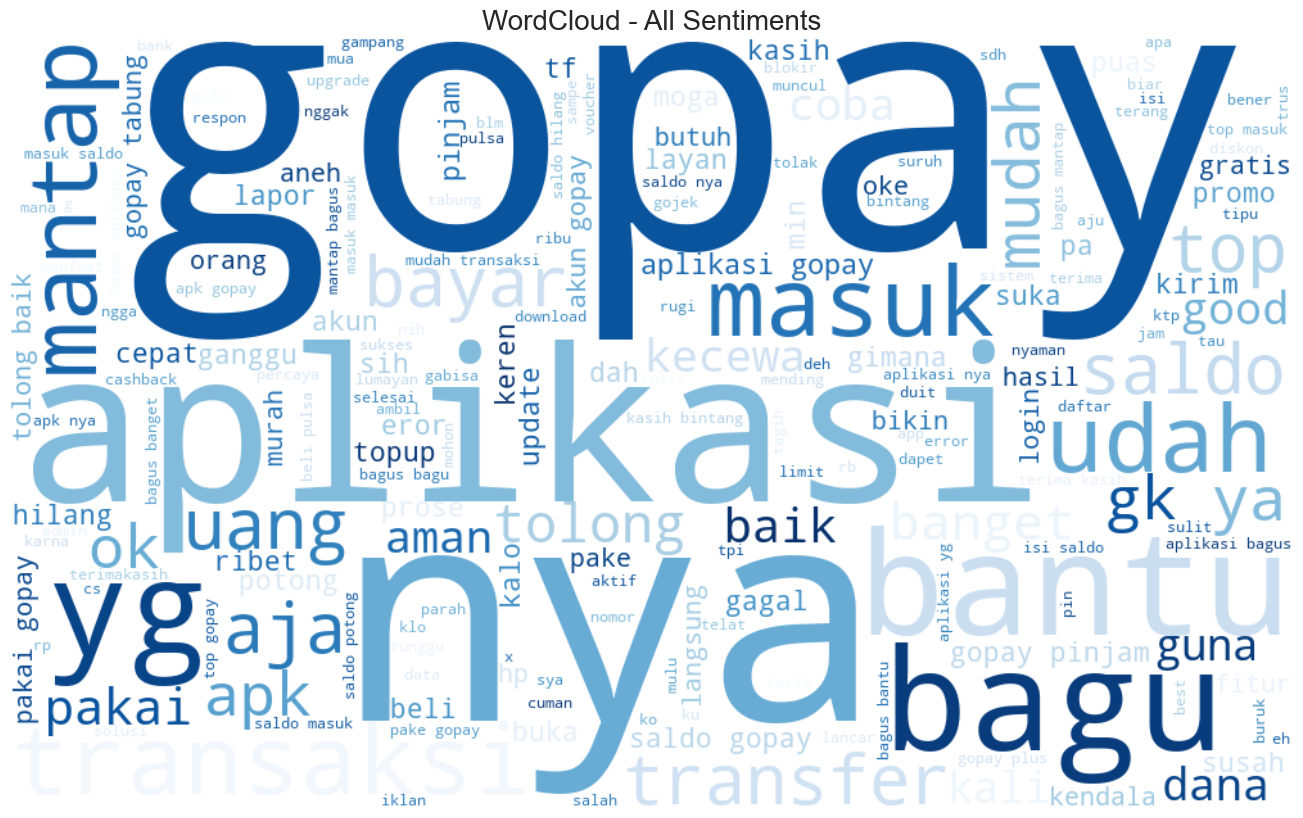

In [28]:
# Gabung semua token dari df['text_token'] jadi satu string
all_words_string = ' '.join([' '.join(tokens) for tokens in df['text_token']])
# Buat WordCloud-nya
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='Blues').generate(all_words_string)

# Tampilkan WordCloud-nya
plt.figure(figsize=(25, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - All Sentiments', fontsize=20)
plt.show()


## 🟢 Kata Umum dalam Sentimen Positif 

In [29]:
# Filter berdasarkan sentimen
Positive_sent = df[df['score_sentiment'] == 'Positive']

# Ambil top words
top = Counter([item for sublist in Positive_sent['text_token'] for item in sublist])
positive = pd.DataFrame(top.most_common(20))
positive.columns = ['Common_words', 'count']

# Tampilkan dengan gradasi
positive.style.background_gradient(cmap='Greens')


,Common_words,count
0,gopay,1611
1,bagus,1521
2,mantap,1007
3,bantu,963
4,aplikasi,893
5,mudah,804
6,nya,578
7,transaksi,478
8,ok,472
9,banget,329


In [32]:
fig = px.bar(positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=800, height=800,color='Common_words')
fig.show()

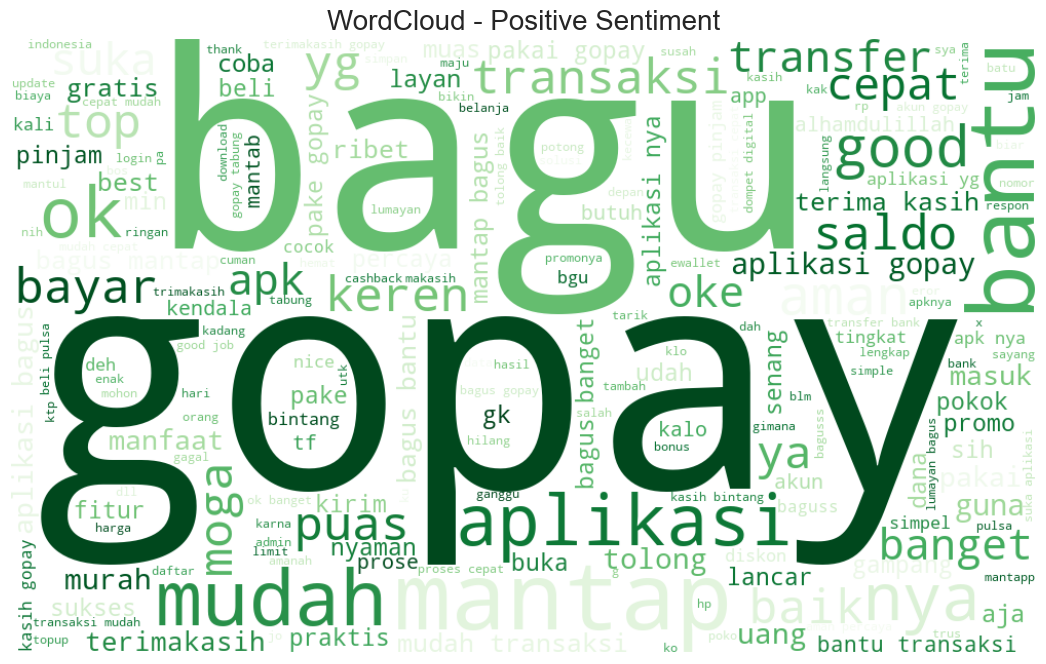

In [34]:
# Filter dulu
positive_words = ' '.join([' '.join(tokens) for tokens in df[df['score_sentiment'] == 'Positive']['text_token']])

# Buat WordCloud
wordcloud_pos = WordCloud(width=1000, height=600, background_color='white', colormap='Greens').generate(positive_words)

# Tampilkan
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Positive Sentiment', fontsize=20)
plt.show()


### Analisis Sentiment Positif

Berdasarkan hasil analisis, dari total sekitar **14.000 data**, terdapat sekitar **8.000 respon** yang menunjukkan **sentimen positif** terhadap aplikasi **GoPay**.

Beberapa **kata yang paling sering muncul** dalam sentimen positif ini adalah sebagai berikut:

| Kata       | Frekuensi |
|------------|-----------|
| gopay      | 1.611     |
| bagus      | 1.521     |
| mantap     | 1.007     |
| bantu      | 963       |
| aplikasi   | 893       |
| mudah      | 804       |

Analisis lebih lanjut menunjukkan bahwa sebagian besar pengguna memberikan sentimen positif karena mereka menganggap bahwa aplikasi GoPay **bagus**, **membantu**, dan **mudah digunakan**.

Hal ini membuktikan bahwa GoPay telah berhasil memberikan pengalaman yang **positif** dan **bermanfaat** bagi banyak penggunanya.


## 🔴 Kata Umum dalam Sentimen Negatif

In [35]:
# Filter berdasarkan sentimen
negatif_sent = df[df['score_sentiment'] == 'Negatif']

# Ambil top words
top = Counter([item for sublist in negatif_sent['text_token'] for item in sublist])
negatif = pd.DataFrame(top.most_common(20))
negatif.columns = ['Common_words', 'count']

# Tampilkan dengan gradasi
negatif.style.background_gradient(cmap='Reds')


,Common_words,count
0,gopay,2394
1,saldo,1378
2,nya,1245
3,masuk,1231
4,aplikasi,1133
5,udah,673
6,top,662
7,bayar,595
8,uang,561
9,aja,540


In [36]:
fig = px.bar(negatif, x="count", y="Common_words", title='Most Commmon Negatif Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

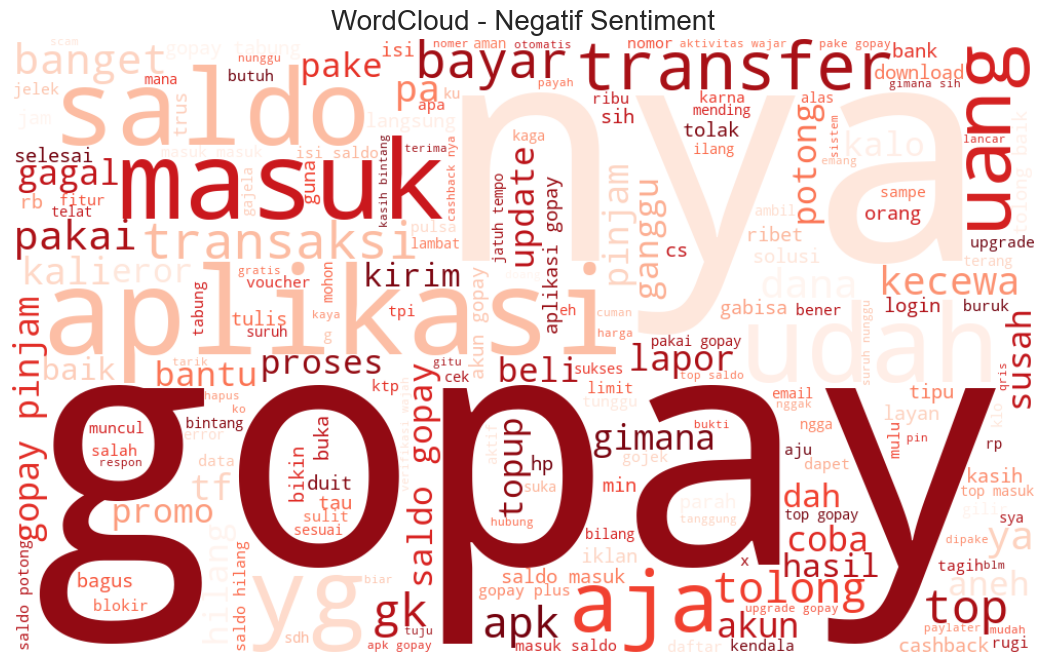

In [37]:
# Filter dulu
negatif_words = ' '.join([' '.join(tokens) for tokens in df[df['score_sentiment'] == 'Negatif']['text_token']])

# Buat WordCloud
wordcloud_pos = WordCloud(width=1000, height=600, background_color='white', colormap='Reds').generate(negatif_words)

# Tampilkan
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negatif Sentiment', fontsize=20)
plt.show()


**-Cek Keluhan Pengguna dengan keyword = 'saldo'**

In [38]:
df[(df['score_sentiment'] == 'Negatif') & (df['content'].str.contains(r'\bSaldo\b', case=False, na=False))]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_akhir,score_sentiment,text_token
17,aa7ed5f2-6e4b-4783-945c-98c0f097213c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Kecewa saldo 300k gk bisa di pake GR"" Otomatis ke tabungan aneh",1,0,1.40.1,2025-02-04 10:14:45,"Hai Kak Oktarianus, mohon maaf atas ketidaknyamanannya. Mengenai kendala tersebut, silakan laporkan melalui email ke customerservice@gopay.co.id dan cantumkan kode psr-25-035-0427-36330 pada subjek email. Kami tunggu detail permasalahannya. ^Maya",2025-02-04 11:27:53,1.40.1,kecewa saldo gk pake gr otomatis tabung aneh,Negatif,"[kecewa, saldo, gk, pake, gr, otomatis, tabung, aneh]"
36,2efb6bc7-f2b4-4eed-9205-d5308352ac4a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Tolong di bantu pihak gopay Kalau kita salah tf.... Di kembali kan saldo nya,1,0,1.40.1,2025-02-04 12:34:27,"Hai Kak Apif, sesuai Syarat & Ketentuan GoPay, jika terjadi kesalahan isi/transfer dan sudah berhasil, maka transaksi tidak dapat dibatalkan. Jika kamu memiliki pertanyaan atau kendala lainnya, silakan kunjungi menu Bantuan di aplikasi GoPay kamu atau email ke customerservice@gopay.co.id. ^Maya",2025-02-04 13:05:13,1.40.1,tolong bantu gopay salah tf saldo nya,Negatif,"[tolong, bantu, gopay, salah, tf, saldo, nya]"
41,60a0ace6-68cf-4aaa-8ce8-0555f536b71a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"gopay nga jelas,, saldo kaga bisa di pake. nga ada kejelasan gopay memaksakan kita nabung d BANK JAGO. tolong pihak PT. GOJEK jgn maksa kita nabung d jago",1,0,NaN,2025-02-04 13:04:57,"Hai Kak Sulaeman, mohon maaf atas ketidaknyamanannya. Mengenai kendala tersebut, silakan laporkan melalui email ke customerservice@gopay.co.id dan cantumkan kode psr-25-035-0702-28758 pada subjek email. Kami tunggu detail permasalahannya. ^Maya",2025-02-04 14:02:37,NaN,gopay nga saldo kaga pake nga jelas gopay paksa nabung bank jago tolong pt gojek jgn maksa nabung jago,Negatif,"[gopay, nga, saldo, kaga, pake, nga, jelas, gopay, paksa, nabung, bank, jago, tolong, pt, gojek, jgn, maksa, nabung, jago]"
45,019b6394-adcb-434f-9cca-b40868749471,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,gopay sial 2 x isi flezz saldo nya gk pernah maauk,1,0,NaN,2025-02-04 13:39:26,"Hai Kak Edi, pastikan nomor kartu yang dimasukkan sudah benar dan kamu sudah update saldo sesuai dengan ketentuan, ya. Jika masih mengalami kendala, silakan laporkan detailnya melalui email ke customerservice@gopay.co.id dan cantumkan kode psr-25-035-0725-13765 pada subjek email. ^Maya",2025-02-04 14:25:25,NaN,gopay sial x isi flezz saldo nya gk maauk,Negatif,"[gopay, sial, x, isi, flezz, saldo, nya, gk, maauk]"
53,9802aa75-73a4-4a5e-8ffd-ab4f80cd2e8d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Pengalaman saya mengenai fitur top up e money di aplikasi gopay sangat buruk,, saldo gopay sudah kepotong tapi saldo belum masuk ke kartu e money.. sudah melakukan update saldo nfc di gopay tidak berhasil alhasil saldo tidak masuk.. tanggapan dari pihak gopay hubungin pihak bank terkait kartu e money.. tolong buat kalian yang mau isi saldo kartu elektronik jagan menggunakan gopay.. terimakasih",1,18,1.40.1,2025-02-04 14:44:42,"Hai Kak Bala, mohon maat atas ketidaknyamanannya. Jika kamu masih mengalami kendala, silakan laporkan melalui email ke customerservice@gopay.co.id dengan melampirkan kode psr-25-035-0812-39144 pada subject email dan cantumkan nomor laporan kamu sebelumnya pada email yang kamu kirimkan. Kami tunggu detail laporan kamu ya. ^Maura",2

**Cek Keluhan Pengguna dengan keyword = 'transfer'**

In [39]:
df[(df['score_sentiment'] == 'Negatif') & (df['content'].str.contains(r'\btransfer\b', case=False, na=False))]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_akhir,score_sentiment,text_token
9,9645cd6c-45fc-4c43-acf1-13277bf255c8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,aplikasi jelek mau transfer aja harus pake gopay plus ga guna,1,0,1.40.1,2025-02-04 08:59:09,"Hai Kak Musrifin, kami infokan untuk menggunakan fitur transfer saldo GoPay, kamu harus terlebih dahulu upgrade akun GoPay-mu ke GoPay Plus, ya. Jika kamu memiliki pertanyaan atau kendala lainnya, silakan kunjungi menu Bantuan di aplikasi GoPay kamu atau email ke customerservice@gopay.co.id. ^Maya",2025-02-04 11:15:12,1.40.1,aplikasi jelek transfer aja pake gopay plus,Negatif,"[aplikasi, jelek, transfer, aja, pake, gopay, plus]"
89,2019236a-ec4f-4892-b561-2a82248a95bc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Hati hati sama ewallet ini saran gw mending pake ewallet yg jelas ,bingung sama ojk bisa masukin gopay....saldo 100k transfer berhasil tapi saldo ga masuk ,chat dan email pun susah ga ada solusi .nyettt lah",1,0,NaN,2025-02-04 18:02:32,"Hai Kak El, mohon maat atas ketidaknyamanannya. Jika kamu masih mengalami kendala, silakan laporkan melalui email ke customerservice@gopay.co.id dengan melampirkan kode psr-25-035-1116-11178 pada subject email dan cantumkan nomor laporan kamu sebelumnya pada email yang kamu kirimkan. Kami tunggu detail laporan kamu ya. ^Maura",2025-02-04 18:16:17,NaN,hati hati ewallet saran mending pake ewallet yg bingung ojk masukin gopaysaldo transfer hasil saldo masuk chat email susah solusi nyettt,Negatif,"[hati, hati, ewallet, saran, mending, pake, ewallet, yg, bingung, ojk, masukin, gopaysaldo, transfer, hasil, saldo, masuk, chat, email, susah, solusi, nyettt]"
177,09d9c9f1-385e-44b0-aad0-25ae3cbc9240,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Dana saya belum masuk mausk padahal sudah di transfer jangn ada yang mau pake apk ini sampah ga masuk masuk da na gw,1,0,1.40.1,2025-02-04 23:32:54,"Hai Kak Satrio, mohon maaf atas ketidaknyamanan yang dialami. Dapat kami sampaikan bahwa sebelumnya terdapat pemeliharaan sistem sehingga transaksi Kakak terhambat sementara. Silakan Kakak untuk melakukan pengecekan secara berkala. Terima kasih. ^Maura",2025-02-04 23:47:08,1.40.1,dana masuk mausk transfer jangn pake apk sampah masuk masuk da na,Negatif,"[dana, masuk, mausk, transfer, jangn, pake, apk, sampah, masuk, masuk, da, na]"
249,7bb49aa1-d6b1-473d-9d38-19810d38a691,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Aplikasinya membingunkan. Semua fiturnya harus scrol kebawah. Padahal dipisah saja menunya per kategori. Seperti transfer | kirim uang | riwayat | dll. Sebagai contoh bisa melihat app d*na atau sh**pepay. Itu detail dan tertata rapi. menunya dipisah per kategori. Tidak membingungkan. Mungkin jika ada perubahan, penilaian akan saya ubah. Thx",2,268,1.40.1,2025-02-05 08:21:13,"Hai Kak Puji, mohon maaf atas ketidaknyamanannya. Laporan yang kamu sampaikan akan menjadi masukan bagi kami untuk terus meningkatkan kualitas layanan kami ke depannya. Jika kamu memiliki pertanyaan atau keluhan terkait layanan GoPay, silakan kunjungi menu Bantuan di aplikasi GoPay kamu atau email ke customerservice@gopay.co.id. ^Miko",2025-02-05 10:01:18,1.40.1,aplikasi membingunkan fiturnya scrol bawah pisah menu kategori transfer kirim uang riwayat dll contoh app dna shpepay detail tata rapi menu pisah kategori bingung ubah nilai ubah thx,Negatif,"[aplikasi, membingunkan, fiturnya, scrol, bawah, pisah, menu, kategori, transfer, kirim, uang, riwayat, dll, contoh, app, dna, shpepay, detail, tata, rapi, menu, pisah, kategori, bingung, ubah,

**Cek Keluhan Pengguna dengan keyword = 'pinjam'**

In [40]:
df[(df['score_sentiment'] == 'Negatif') & (df['content'].str.contains('pinjam', case=False, na=False))]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_akhir,score_sentiment,text_token
34,016f1541-3e4d-4891-aa9c-460a44f06718,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Mohon maaf bintang dua sementara, sudah sering transaksi pakai gopay, namun masih tetap tidak bisa mengajukan difitur gopay pinjam, sungguh terlalu",2,0,1.40.1,2025-02-04 12:11:19,"Hai Kak Ibnu, mohon maaf atas kendala yang kamu alami terkait GoPay Pinjam. Agar masalahnya dapat segera kami bantu, silakan ceritakan lebih lanjut kepada kami melalui email ke support@findaya.com dan cantumkan kode psr-25-035-0603-07495 di subjek email, ya. ^Maya",2025-02-04 13:03:16,1.40.1,mohon maaf bintang transaksi pakai gopay aju difitur gopay pinjam sungguh,Negatif,"[mohon, maaf, bintang, transaksi, pakai, gopay, aju, difitur, gopay, pinjam, sungguh]"
99,15f002aa-65c3-4da0-a3a6-cc47722f3b4b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Pengajuan gopay pinjam selalu di tolak,1,0,1.40.1,2025-02-04 18:35:56,"Hai Kak Kodiarno, mohon maaf atas kendala yang kamu alami terkait GoPay Pinjam. Agar masalahnya dapat segera kami bantu, silakan ceritakan lebih lanjut kepada kami melalui email ke support@findaya.com dan cantumkan kode psr-25-035-1208-41284 di subjek email, ya. ^Maura",2025-02-04 19:08:49,1.40.1,aju gopay pinjam tolak,Negatif,"[aju, gopay, pinjam, tolak]"
164,08a1b99b-8c90-42bf-9c67-2677d1dc48ca,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Udah payah² cari uang utk lunasin pinjaman eh gk taunya malah ditolak utk pinjaman lagi padahal udah tahap 3 yg pinjam!!! Untuk pengelola Gopay pinjam dimohon klarifikasinya.,1,0,1.40.1,2025-02-04 22:11:00,"Hai Kak Hadi, mohon maaf atas kendala yang kamu alami terkait GoPay Pinjam. Agar masalahnya dapat segera kami bantu, silakan ceritakan lebih lanjut kepada kami melalui email ke support@findaya.com dan cantumkan kode psr-25-035-1545-34220 di subjek email, ya. ^Maura",2025-02-04 22:45:42,1.40.1,udah payah cari uang utk lunasin pinjam eh gk tau tolak utk pinjam udah tahap yg pinjam kelola gopay pinjam mohon klarifikasi,Negatif,"[udah, payah, cari, uang, utk, lunasin, pinjam, eh, gk, tau, tolak, utk, pinjam, udah, tahap, yg, pinjam, kelola, gopay, pinjam, mohon, klarifikasi]"
313,68ae5eca-56d3-483b-909d-ef7965f65142,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Kenapa sudah bayar tagihan gopay pinjam tapi di aplikasi masih tertera harus di bayar sudah minta bantuan tapi tidak ada balasan mohon bantuan nya admin Baru pertama kali ngalamin kejadian kyk gini padahal udah sering transaksi di gopay baik"" ajah",1,0,1.28.0,2025-02-05 13:16:02,"Hai Kak Ari, mohon maaf atas ketidaknyamanannya. Saat ini kami sedang melakukan pemeliharaan sistem untuk memberikan pelayanan yang lebih baik buat Kakak. Kakak bisa refresh dan lakukan pengecekan secara berkala ya. Semoga informasi kami membantu. ^Miko",2025-02-05 15:08:45,1.28.0,bayar tagih gopay pinjam aplikasi tera bayar bantu balas mohon bantu nya admin kali ngalamin jadi kyk gin udah transaksi gopay ajah,Negatif,"[bayar, tagih, gopay, pinjam, aplikasi, tera, bayar, bantu, balas, mohon, bantu, nya, admin, kali, ngalamin, jadi, kyk, gin, udah, transaksi, gopay, ajah]"
392,4aca4d4d-d816-4501-9b44-7fd36470ac7a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Gaya ngasih limit pinjaman 500rb, begitu di test cairin, ditolak. Di apk sebelah aja (kredivo, akulaku, shopee) limit yg dikasih bisa dicairkan. LoL",1,0,1.40.1,2025-02-05 19:27:37,"Hai Kak Ekin, mohon maaf atas kendala yang kamu alami

### Analisis Sentiment Negatif 

Dari total sekitar **14.000 data sentimen**, ditemukan lebih dari **5.000 sentimen negatif** yang berkaitan erat dengan **fitur inti di aplikasi Gopay** yaitu: **Saldo, Transfer, dan Pinjam**.

* **💸 Keyword: Saldo**
    - Pengguna mengeluh saldo **tidak masuk** atau **berkurang tiba-tiba** tanpa alasan jelas.
    - Saldo sering **dipindahkan otomatis** ke fitur **Gopay Tabungan** tanpa izin.
    - Proses **top-up sering error**, bikin khawatir saldo hilang.
    - Layanan **customer service lambat**, hanya dijawab bot tanpa solusi konkret.

* **🔁 Keyword: Transfer**
    - Banyak kejadian **transfer gagal** tapi saldo tetap terpotong.
    - Gagal **upgrade ke Gopay Plus (KYC)** yang merupakan syarat penting untuk transfer.
    - Fitur **Gopay Tabungan** membingungkan dan **tidak user-friendly**.
    - **CS tidak responsif** dan solusi yang diberikan tidak menyelesaikan masalah.

* **🏦 Keyword: Pinjam**
    - **Pengajuan pinjaman ditolak** tanpa penjelasan meskipun histori pengguna bagus.
    - Sistem **evaluasi kredit** dinilai **tidak adil dan tidak transparan**.
    - Banyak error saat **pelunasan** dan denda karena bug sistem.
    - Beberapa pengguna merasa **diancam** atau **diintimidasi** ketika telat bayar.
    - Promo pinjaman sering dikirim, tapi saat diajukan selalu **ditolak** → membuat frustrasi.

---

**🧠 Kesimpulan Umum**

Sentimen negatif ini menandakan **penurunan kepercayaan pengguna** terhadap fitur utama Gopay akibat:
- **Fitur gagal berfungsi optimal**, bikin frustrasi.
- **Kurangnya transparansi** dan **penilaian sistem yang tidak adil**.
- **Pengalaman pengguna yang buruk** dan rasa tidak aman secara finansial.

---

**✅ Rekomendasi Strategis**

Untuk mengatasi berbagai masalah yang muncul dari analisis sentimen negatif ini, berikut beberapa langkah yang direkomendasikan:

1. **Perbaiki Komunikasi & Transparansi**
   - Sediakan notifikasi real-time dan penjelasan transparan jika transaksi gagal atau pengajuan ditolak.
   - Buat dashboard status transaksi, saldo, dan proses pinjaman agar user bisa tracking mandiri.

2. **Tingkatkan Kualitas Fitur & UX**
   - Evaluasi dan benahi fitur Gopay Tabungan, top-up, dan transfer agar lebih stabil dan mudah dipahami.
   - Permudah proses verifikasi KYC dengan alur yang jelas dan tidak menyulitkan pengguna.

3. **Customer Service yang Responsif**
   - Hadirkan fitur live chat dengan **agent manusia**, bukan hanya chatbot.
   - Buat sistem pelaporan dengan nomor tiket agar pengguna bisa follow-up keluhannya.

4. **Evaluasi Pinjaman yang Lebih Adil**
   - Bangun sistem penilaian berbasis data yang adil dan terbuka.
   - Berikan umpan balik yang jelas saat pengajuan pinjaman ditolak.

5. **Kembalikan Kontrol Fitur ke Tangan Pengguna**
   - Hindari pengaktifan otomatis seperti Gopay Tabungan.
   - Pastikan semua fitur bisa diaktifkan/dinonaktifkan sesuai keinginan pengguna.

---

> 🔍 **Catatan**: Analisis ini dilakukan karena seluruh keluhan pengguna berhubungan langsung dengan **fitur-fitur utama Gopay**. Fokus peningkatan pada area-area tersebut sangat penting untuk mengembalikan kepercayaan dan pengalaman positif pengguna.

## ⚪ Kata Umum dalam Sentiment Netral

In [41]:
# Filter berdasarkan sentimen
neutral_sent = df[df['score_sentiment'] == 'Neutral']

# Ambil top words
top = Counter([item for sublist in neutral_sent['text_token'] for item in sublist])
neutral = pd.DataFrame(top.most_common(20))
neutral.columns = ['Common_words', 'count']

# Tampilkan dengan gradasi
neutral.style.background_gradient(cmap='YlOrBr')


,Common_words,count
0,gopay,281
1,nya,161
2,saldo,115
3,aplikasi,105
4,masuk,99
5,tolong,82
6,ya,75
7,bagus,71
8,udah,64
9,pinjam,63


In [42]:
fig = px.bar(neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

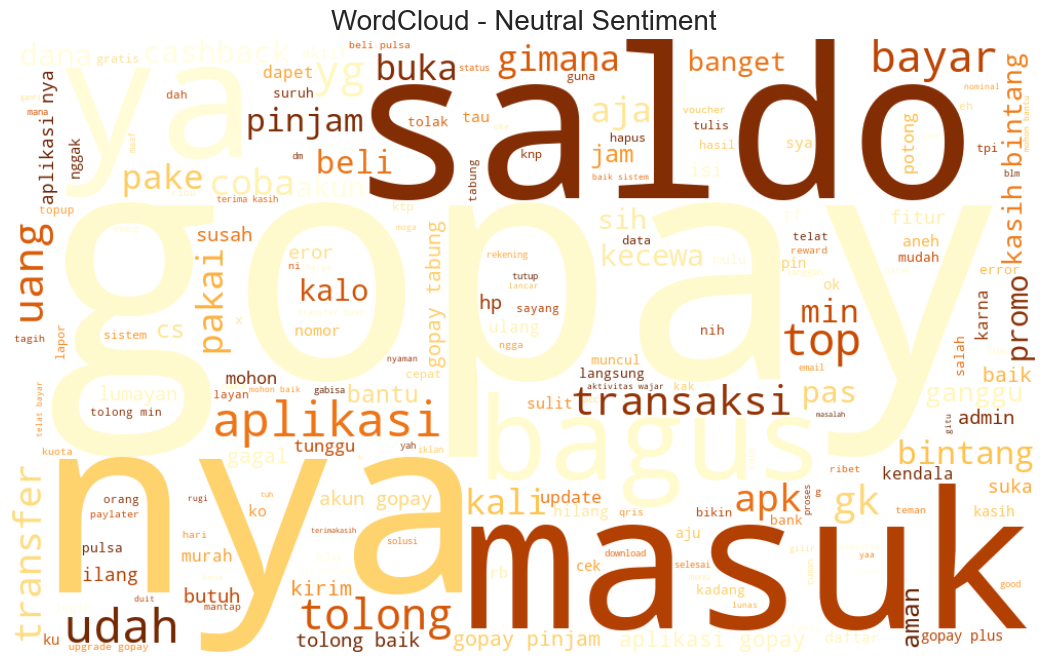

In [43]:
# Filter dulu
neutral_words = ' '.join([' '.join(tokens) for tokens in df[df['score_sentiment'] == 'Neutral']['text_token']])

# Buat WordCloud
wordcloud_pos = WordCloud(width=1000, height=600, background_color='white', colormap='YlOrBr').generate(neutral_words)

# Tampilkan
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Neutral Sentiment', fontsize=20)
plt.show()


In [44]:
df[(df['score_sentiment'] == 'Neutral') & (df['content'].str.contains('aplikasi', case=False, na=False))]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_akhir,score_sentiment,text_token
81,f24c11ba-e32f-4cff-b8bd-5be9464dbdc3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"aplikasi nya sih udah bagus tapi saya kesal kenapa setiap saya mau ke pembayaran terus muncul tulisan ""kami mendeteksi aktivitas gak wajar"" itu kenapa ya, itu aja sih, sekian terima kasih",3,0,1.40.1,2025-02-04 17:32:24,"Hai Kak Vannezar, mohon maat atas ketidaknyamanannya. Terkait keluhan tersebut, silakan laporkan melalui email ke customerservice@gopay.co.id dengan melampirkan kode psr-25-035-1044-33639 pada subject email dan cantumkan nomor laporan kamu sebelumnya pada email yang kamu kirimkan. Kami tunggu detail laporan kamu ya. ^Maura",2025-02-04 17:44:41,1.40.1,aplikasi nya sih udah bagus kesal bayar muncul tulis deteksi aktivitas wajar ya aja sih sekian terima kasih,Neutral,"[aplikasi, nya, sih, udah, bagus, kesal, bayar, muncul, tulis, deteksi, aktivitas, wajar, ya, aja, sih, sekian, terima, kasih]"
286,77a7a9db-2713-4dab-922e-4b2c093c4176,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Udah dftr data masuk juga gak bsa di hps akunnya pengajuan gopinjam di tolak Mhn jangan sebarkan salahgunakan data saya mulai detik nih per tgl 5feb 2025 jg akan saya unistal aplikasinya.. Terimakasih,3,0,1.40.1,2025-02-05 10:45:09,"Hai Kak Destri, mohon maaf atas kendala yang kamu alami terkait GoPay Pinjam. Agar masalahnya dapat segera kami bantu, silakan ceritakan lebih lanjut kepada kami melalui email ke support@findaya.com dan cantumkan kode psr-24-327-0525-47838 di subjek email, ya. ^Maya",2024-11-22 12:25:56,1.40.1,udah dftr data masuk hps akun aju gopinjam tolak mhn sebar salahgunakan data detik nih tgl feb unistal aplikasi terimakasih,Neutral,"[udah, dftr, data, masuk, hps, akun, aju, gopinjam, tolak, mhn, sebar, salahgunakan, data, detik, nih, tgl, feb, unistal, aplikasi, terimakasih]"
603,34bd3ce5-16ff-42d1-b9f6-902539ae0e6b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Mau komplain kode voucher salah, nggak bisa di aplikasinya",3,1,1.40.1,2025-02-06 18:05:57,"Hai Kak Maghfiroh, mohon maaf atas ketidaknyamanannya. Terkait laporanmu sudah ada tiket dinomor 208000997 dan sedang ditangani oleh tim kami. Kamu dapat melakukan pengecekkan progress-nya di menu My Ticket aplikasi GoPay atau Gojek kamu ya. ^Miko",2025-02-07 17:51:46,1.40.1,komplain kode voucher salah nggak aplikasi,Neutral,"[komplain, kode, voucher, salah, nggak, aplikasi]"
670,e35fe954-2142-4c63-b4ca-b702dbfeb202,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Tiba"" uangku ilang karena langganan salah satu game, padahal udh ngga ada aplikasinya lagi. Trs kalo beli kuota juga ga masuk padahal udh beli 100.000 ilang percuma😞💔",3,0,1.40.1,2025-02-07 00:17:25,"Hai Kak Sabrina, mohon maat atas ketidaknyamanannya. Terkait keluhan tersebut, silakan laporkan melalui email ke customerservice@gopay.co.id dengan melampirkan kode psr-25-038-0009-38484pada subject email dan cantumkan nomor laporan kamu sebelumnya pada email yang kamu kirimkan. Kami tunggu detail laporan kamu ya. ^Maura",2025-02-07 07:09:50,1.40.1,uang ilang langgan salah game ngga aplikasi kalo beli kuota masuk beli ilang,Neutral,"[uang, ilang, langgan, salah, game, ngga, aplikasi, kalo, beli, kuota, masuk, beli, ilang]"
906,142028e0-0d94-45fb-bfe3-cadf76b7141f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Sistem sering bermasalah Transaksi bermasalah Apa lagi Tengah malam Tarik data jangan mengganggu penggunaan aplikasi Buat noti

In [45]:
df[(df['score_sentiment'] == 'Neutral') & (df['content'].str.contains('saldo', case=False, na=False))]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_akhir,score_sentiment,text_token
29,e6b59d06-e0cb-4ddc-bde4-8c86ce069c5d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Tau2 saldo gopay beralih ke gopay tabungan,,dn smpe skrg msh belum bisa trnsksi tuh saldo beku",3,0,1.40.1,2025-02-04 11:38:40,"Hai Kak Kartika, mohon maaf atas ketidaknyamanannya. Mengenai kendala tersebut, silakan laporkan melalui email ke customerservice@gopay.co.id dan cantumkan kode psr-25-035-0541-31695 pada subjek email. Kami tunggu detail permasalahannya. ^Maya",2025-02-04 12:41:40,1.40.1,tau saldo gopay alih gopay tabungandn skrg msh trnsksi tuh saldo beku,Neutral,"[tau, saldo, gopay, alih, gopay, tabungandn, skrg, msh, trnsksi, tuh, saldo, beku]"
67,bec656ec-0b92-4cb6-a10c-bd1b79f64e10,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Taikk saldo ghaib, hilang gitu aja",3,0,1.40.1,2025-02-04 16:20:12,"Hai Kak Hendrick, mohon maat atas ketidaknyamanannya. Terkait keluhan tersebut, silakan laporkan melalui email ke customerservice@gopay.co.id dengan melampirkan kode psr-25-035-0942-36190 pada subject email dan cantumkan nomor laporan kamu sebelumnya pada email yang kamu kirimkan. Kami tunggu detail laporan kamu ya. ^Maura",2025-02-04 16:42:43,1.40.1,taikk saldo ghaib hilang gitu aja,Neutral,"[taikk, saldo, ghaib, hilang, gitu, aja]"
146,0877633d-2589-403a-9346-4bfa8bf8b852,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Saya melakukan top up dari bank bni ke gopay laporan berhasil kok saldo tidak masuk ya,3,0,1.40.1,2025-02-04 21:10:04,"Hai Kak Agustinus, mohon maaf atas ketidaknyamanan yang dialami. Dapat kami sampaikan bahwa sebelumnya terdapat pemeliharaan sistem sehingga transaksi Kakak terhambat sementara. Silakan Kakak untuk melakukan pengecekan secara berkala. Terima kasih. ^Maura",2025-02-04 21:45:51,1.40.1,top bank bni gopay lapor hasil saldo masuk ya,Neutral,"[top, bank, bni, gopay, lapor, hasil, saldo, masuk, ya]"
299,06f178be-6c3e-436a-884f-ac24711e07e9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Apakah uang nya bisa kembali ke saldo bca atau akan masuk ke gopai saya,3,0,NaN,2025-02-05 12:23:08,"Hai Kak @Link 1933, mohon maaf atas ketidaknyamanannya. Saat ini kami sedang melakukan pemeliharaan sistem untuk memberikan pelayanan yang lebih baik buat Kakak. Kakak bisa refresh dan lakukan pengecekan secara berkala ya. Semoga informasi kami membantu. ^Miko",2025-02-05 12:17:27,NaN,uang nya saldo bca masuk gopai,Neutral,"[uang, nya, saldo, bca, masuk, gopai]"
400,67557b10-8d05-4875-a28a-88af6b68cbc7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Akun gopay lama saya yang udah gopay plus udah dihapus karena udah ga dipakai, pas saya mau daftar ulang bikin gopay baru pakai ktp dan muka saya kenapa ditolak terus ya? Apa karena sudah terpakai, walaupun akun yang lama udah dihapus? Tolong dijawab min, soalnya akun yang ini ada saldonya mau transfer pun gabisa jadinya ga bisa kemana"" saldonya.",3,0,1.40.1,2025-02-05 20:13:13,"Mohon maaf, Kak Rizki. Demi menjaga keamanan transaksimu, terdapat pembaruan syarat & ketentuan akun GoPay Plus, yaitu satu ID (eKTP) hanya dapat digunakan di satu akun. Agar dapat dibantu lebih lanjut, silakan laporkan detailnya melalui email customerservice@gopay.co.id dengan melampirkan kode psr-25-036-1540-19694 pada subjek email. ^Maya",2025-02-05 22:40:27,1.40.1,akun gopay udah gopay plus udah hapus udah pakai pas daftar ulang bikin gopay pakai ktp muka tolak ya pakai akun udah hapus tolong min akun saldo transf

In [46]:
df[(df['score_sentiment'] == 'Neutral') & (df['content'].str.contains('tolong', case=False, na=False))]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_akhir,score_sentiment,text_token
106,577e3626-8a5b-4419-af7f-cf83cdaa11f4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Bagus tolong di perbaiki sistemnya ya,3,0,1.40.1,2025-02-04 18:54:51,"Hai Kak Imam, terima kasih atas ulasanmu. Kritik dan saran yang kamu berikan akan menjadi masukan bagi kami untuk terus meningkatkan kualitas layanan kami ke depannya. Jika kamu memiliki pertanyaan atau kendala lainnya, silakan kunjungi menu Bantuan di aplikasi GoPay kamu. ^Maura",2025-02-04 19:17:55,1.40.1,bagus tolong baik sistem ya,Neutral,"[bagus, tolong, baik, sistem, ya]"
200,5182167f-897a-4ce5-9e51-33f836f3a556,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Kenapa saya gak bisa transfer ke bank atau e-wallet...? Padahal BRI sama DANA gak lg maintenance tp keterangannya undermaintenance dicoba ke BNI pun gak bisa.. Tolong direspon dan dibantu..!!,3,1,1.40.1,2025-02-05 01:49:49,"Hai Kak Mamay, sebelum transfer, pastikan status upgrade GoPay Plus sudah 'Diterima', nomor penerima valid dan tidak terblokir. Jika masih bermasalah, silakan kunjungi menu Bantuan di aplikasi GoPay atau email ke customerservice@gopay.co.id dan cantumkan kode psr-25-036-0105-17446 pada subjek email. ^Miko",2025-02-05 08:05:48,1.40.1,transfer bank ewallet bri dana maintenance terang undermaintenance coba bni tolong direspon bantu,Neutral,"[transfer, bank, ewallet, bri, dana, maintenance, terang, undermaintenance, coba, bni, tolong, direspon, bantu]"
306,c15ad67d-374a-4fca-8275-d7d86dc3dcb3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,Tolong jangan muncul lagi iklan ni.di hp saya paham,3,0,NaN,2025-02-05 12:54:52,"Hai Kak @Kodier Exzo, mohon maaf atas ketidaknyamanannya. Laporan yang kamu sampaikan akan menjadi masukan bagi kami untuk terus meningkatkan kualitas layanan kami ke depannya. Jika kamu memiliki pertanyaan atau keluhan terkait layanan GoPay, silakan kunjungi menu Bantuan di aplikasi GoPay kamu atau email ke customerservice@gopay.co.id. ^Miko",2025-02-05 14:58:55,NaN,tolong muncul iklan nidi hp paham,Neutral,"[tolong, muncul, iklan, nidi, hp, paham]"
321,73a16494-805d-4beb-8383-ef6f6162ed03,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Gopay kok skrng di aku jdi eror trus ya? Lgi transaksi tiba² aj out sndiri dri apk nya, pdhal dulu ngga begini. Tolong di perbaiki lgi ya🙏🏻🙏🏻🙏🏻",3,0,1.39.0,2025-02-05 13:54:02,"Mohon maaf, Kak Dwi. Terkait laporanmu, pastikan sinyal internetmu stabil, aktifkan 'App Permission'/'Izinkan Aplikasi', lalu logout kemudian login kembali. Untuk kendala login lainnya, silakan mengakses halaman bantuan login pada aplikasi GoPay. ^Maya",2025-02-05 16:27:24,1.39.0,gopay skrng jdi eror trus ya lgi transaksi tiba aj sndiri dri apk nya pdhal ngga tolong baik lgi ya,Neutral,"[gopay, skrng, jdi, eror, trus, ya, lgi, transaksi, tiba, aj, sndiri, dri, apk, nya, pdhal, ngga, tolong, baik, lgi, ya]"
343,bf957c31-ff59-4531-a2a2-fe73078d855f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"bbrp kali setiap top up selalu tidak masuk , dan tertunda, tolong segera di perbaiki, kdng kita perlu uangnya",3,0,1.40.1,2025-02-05 15:16:41,"Hai Kak Nurhadi, pastikan nomor tujuan sudah benar, sudah cek halaman Riwayat, dan coba keluar dan masuk kembali ke aplikasi. Jika saldo masih belum masuk, silakan laporkan melalui menu Bantuan > ketik 'Top up GoPay saya belum masuk' > isi formulir dan cantumkan kode psr-25-036-1006-45625 pada bagian 'Ceritakan lebih lanjut'. ^Maya",2025-02-05 17:06:54,1.

### Analisis Sentimen Neutral

Dari total lebih dari **14.000 data**, ditemukan sebanyak **738 data** yang berlabel **sentimen netral**. Namun setelah dilakukan analisis lebih dalam, ternyata data ini memiliki kecenderungan **menjorok ke arah negatif**. Hal ini terlihat dari kata kunci yang sering muncul dan konteks kalimat yang digunakan oleh para pengguna.

Berikut ini adalah hasil klasifikasi berdasarkan keyword utama:

* **🔹 Keyword : aplikasi**
    - Banyak pengguna mengalami error saat membuka aplikasi, terjadi crash, atau otomatis logout.
    - Upgrade ke **GoPay Tabungan** justru menyebabkan aplikasi menjadi tidak stabil atau sulit digunakan.
    - Beberapa akun mengalami perubahan status (misalnya GoPay Plus menjadi Basic) setelah berpindah perangkat.
    - Keluhan tentang user experience yang semakin rumit dibandingkan versi sebelumnya.


* **🔹 Keyword : saldo**
    - **Saldo hilang** atau berkurang tanpa alasan yang jelas.
    - Proses transfer saldo sering mengalami gangguan, nyangkut, delay, atau tidak bisa digunakan.
    - Saldo yang dipindahkan ke GoPay Tabungan muncul sebagai **saldo 0**.
    - Cashback, top-up, atau promosi yang dijanjikan tidak masuk ke saldo pengguna.
    - Banyak pengguna merasa bingung bagaimana cara melaporkan atau mengakses kembali saldo yang bermasalah.


* **🔹 Keyword : tolong**
    - Banyak permintaan bantuan terkait saldo yang tidak masuk, akun error, atau tidak bisa digunakan.
    - Nada yang digunakan menunjukkan **kebingungan dan frustrasi**, meskipun masih ada harapan agar dibantu oleh customer service.
    - Keluhan terkait **lambatnya respon customer service** dan sistem pelaporan yang tidak transparan.

---

**🎯 Kesimpulan**

Walaupun data-data ini secara label termasuk dalam kategori *netral*, namun konteks isi menunjukkan **indikasi sentimen negatif** yang cukup kuat. Ini menunjukkan bahwa sistem labeling sentimen perlu dievaluasi, dan tim produk harus waspada terhadap “sentimen netral yang berpotensi menjadi keluhan besar”.


## Kesimpulan EDA & Visualization
**📊 Distribusi Sentimen GoPay**

💬 Total data: ±14.000 respon

- 🟢 **Positif**: 8.813 respon (mayoritas)  
- 🔴 **Negatif**: 5.075 respon (perlu perhatian serius)  
- ⚪ **Netral**: 738 respon (jumlah kecil, tapi berpotensi negatif)  

---

**🧠 Insight Analisis Sentimen GoPay**

**💚 Sentimen Positif**  
Mayoritas pengguna memberikan ulasan positif terhadap GoPay, terutama karena kemudahan penggunaan dan manfaat aplikasi dalam kehidupan sehari-hari.

Kata-kata seperti *“bagus”*, *“mudah”*, *“mantap”*, dan *“bantu”* menjadi keyword dominan yang muncul dalam ulasan ini. Ini mencerminkan bahwa **GoPay telah memberikan pengalaman yang memuaskan dan membantu aktivitas finansial pengguna.**

**💔 Sentimen Negatif**  
Lebih dari 5.000 respon menunjukkan adanya masalah serius di fitur utama, terutama:

- 💸 **Saldo**: hilang tiba-tiba, pindah otomatis ke tabungan tanpa izin, top-up error, dan CS lambat.  
- 🔁 **Transfer**: gagal tapi saldo kepotong, gagal upgrade Gopay Plus (KYC), fitur tidak user-friendly.  
- 🏦 **Pinjam**: pengajuan ditolak tanpa alasan, sistem penilaian tidak adil, error saat pelunasan, hingga intimidasi saat telat bayar.  

Ini menunjukkan bahwa **fitur inti GoPay belum optimal** dan membuat pengguna kehilangan rasa aman dalam mengelola keuangan mereka.

**🤍 Sentimen Netral (tapi condong negatif)**  
Meskipun hanya sekitar 700-an data yang berlabel netral, sebagian besar isinya menunjukkan:

- Keluhan aplikasi yang crash, logout sendiri, atau downgrade akun setelah pindah device.  
- Masalah saldo seperti tidak masuk, delay transfer, dan saldo tabungan jadi nol.  
- Banyak permintaan tolong yang bernada frustrasi karena minimnya bantuan nyata dari CS.  

> Artinya, meskipun secara sistem diberi label *netral*, data ini sebenarnya **mengandung potensi keluhan besar** yang bisa merusak reputasi GoPay jika tidak segera ditangani.

---

**📌 Kesimpulan**  
GoPay memang mendapat banyak apresiasi dari pengguna, tapi juga menghadapi tantangan besar di fitur-fitur krusial. **Perbaikan fitur, transparansi transaksi, dan layanan pelanggan yang lebih manusiawi** wajib dilakukan untuk menjaga kepercayaan user dan mendorong pertumbuhan lebih lanjut.


**📊 Distribusi Sentimen GoPay (KPI)**  
💬 Total data: ±14.000 respon

- 🟢 **Positif**: 8.813 respon (mayoritas)  
- 🔴 **Negatif**: 5.075 respon (perlu perhatian serius)  
- ⚪ **Netral**: 738 respon (jumlah kecil, tapi berpotensi negatif)  

---

**🧠 Insight Analisis Sentimen GoPay**

**💚 Sentimen Positif**  
Mayoritas pengguna memberikan ulasan positif terhadap GoPay, terutama karena kemudahan penggunaan dan manfaat aplikasi dalam kehidupan sehari-hari. Kata-kata seperti *“bagus”*, *“mudah”*, *“mantap”*, dan *“bantu”* menjadi keyword dominan yang muncul dalam ulasan ini. Ini mencerminkan bahwa **GoPay telah memberikan pengalaman yang memuaskan dan membantu aktivitas finansial pengguna.**

**💔 Sentimen Negatif**  
Lebih dari 5.000 respon menunjukkan adanya masalah serius di fitur utama, terutama:

- 💸 **Saldo**: hilang tiba-tiba, pindah otomatis ke tabungan tanpa izin, top-up error, dan CS lambat.  
- 🔁 **Transfer**: gagal tapi saldo kepotong, gagal upgrade Gopay Plus (KYC), fitur tidak user-friendly.  
- 🏦 **Pinjam**: pengajuan ditolak tanpa alasan, sistem penilaian tidak adil, error saat pelunasan, hingga intimidasi saat telat bayar.  

Ini menunjukkan bahwa **fitur inti GoPay belum optimal** dan membuat pengguna kehilangan rasa aman dalam mengelola keuangan mereka.

**🤍 Sentimen Netral (tapi condong negatif)**  
Meskipun hanya sekitar 700-an data yang berlabel netral, sebagian besar isinya menunjukkan:

- Keluhan aplikasi yang crash, logout sendiri, atau downgrade akun setelah pindah device.  
- Masalah saldo seperti tidak masuk, delay transfer, dan saldo tabungan jadi nol.  
- Banyak permintaan tolong yang bernada frustrasi karena minimnya bantuan nyata dari CS.  

> Artinya, meskipun secara sistem diberi label *netral*, data ini sebenarnya **mengandung potensi keluhan besar** yang bisa merusak reputasi GoPay jika tidak segera ditangani.

---

**📌 Kesimpulan**  
GoPay memang mendapat banyak apresiasi dari pengguna, tapi juga menghadapi tantangan besar di fitur-fitur krusial. **Perbaikan fitur, transparansi transaksi, dan layanan pelanggan yang lebih manusiawi** wajib dilakukan untuk menjaga kepercayaan user dan mendorong pertumbuhan lebih lanjut.


# Modelling

## A. Modelling Menggunakan Ekstraksi Fitur TF-IDF & Algoritma Machine Learning

**1. Pelatihan: Naive Bayes, Ekstraksi Fitur: TF-IDF, Pembagian Data: 80/20**

In [47]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, min_df=10, max_df=0.85)
X_tfidf = tfidf.fit_transform(df['text_akhir'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['score_sentiment'], test_size=0.2, random_state=42)

# Model - Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predictions
y_pred_train_nb = nb.predict(X_train)
y_pred_test_nb = nb.predict(X_test)

# Accuracy
train_accuracy_nb = accuracy_score(y_train, y_pred_train_nb)
test_accuracy_nb = accuracy_score(y_test, y_pred_test_nb)

# Classification report
report_nb = classification_report(y_test, y_pred_test_nb, output_dict=True)
precision_nb = report_nb['weighted avg']['precision']
recall_nb = report_nb['weighted avg']['recall']
f1_nb = report_nb['weighted avg']['f1-score']

# Summary DataFrame
df_nb_summary = pd.DataFrame([{
    'model': 'Naive Bayes',
    'accuracy': round(train_accuracy_nb * 100, 2),
    'test_accuracy': round(test_accuracy_nb * 100, 2),
    'precision': round(precision_nb * 100, 2),
    'recall': round(recall_nb * 100, 2),
    'f1_score': round(f1_nb * 100, 2)
}])


c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**2. Pelatihan: Logistic Regression, Ekstraksi Fitur: TF-IDF, Pembagian Data: 80/20**

In [48]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, min_df=10, max_df=0.7, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['text_akhir'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['score_sentiment'], test_size=0.2, random_state=42)

# Model - Logistic Regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1500)
lr.fit(X_train, y_train)

# Predictions
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

# Accuracy
train_accuracy_lr = accuracy_score(y_train, y_pred_train_lr)
test_accuracy_lr = accuracy_score(y_test, y_pred_test_lr)

# Classification report
report_lr = classification_report(y_test, y_pred_test_lr, output_dict=True)
precision_lr = report_lr['weighted avg']['precision']
recall_lr = report_lr['weighted avg']['recall']
f1_lr = report_lr['weighted avg']['f1-score']

# Summary DataFrame
df_lr_summary = pd.DataFrame([{
    'model': 'Logistic Regression',
    'accuracy': round(train_accuracy_lr * 100, 2),
    'test_accuracy': round(test_accuracy_lr * 100, 2),
    'precision': round(precision_lr * 100, 2),
    'recall': round(recall_lr * 100, 2),
    'f1_score': round(f1_lr * 100, 2)
}])


**3. Pelatihan: Support Vector Machine, Ekstraksi Fitur: TF-IDF, Pembagian Data: 80/20**

In [49]:
# Vectorization
tfidf = TfidfVectorizer(max_features=1000, min_df=10, max_df=0.7, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['text_akhir'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['score_sentiment'], test_size=0.2, random_state=42)

# Model - SVM
svc = SVC(kernel='linear', C=1.0, decision_function_shape='ovo')
svc.fit(X_train, y_train)

# Predictions
y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Classification report
report = classification_report(y_test, y_pred_test, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Summary DataFrame
df_svm_summary = pd.DataFrame([{
    'model': 'SVM',
    'accuracy': round(train_accuracy * 100, 2),
    'test_accuracy': round(test_accuracy * 100, 2),
    'precision': round(precision * 100, 2),
    'recall': round(recall * 100, 2),
    'f1_score': round(f1 * 100, 2)
}])


c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [51]:
df_svm_summary

,model,accuracy,test_accuracy,precision,recall,f1_score
0,SVM,87.25,85.2,80.66,85.2,82.84


**Gabungkan Hasil evaluasi per Model Machine Learning**

In [52]:
final_df = pd.concat([df_lr_summary, df_svm_summary, df_nb_summary], ignore_index=True)
final_df

,model,accuracy,test_accuracy,precision,recall,f1_score
0,Logistic Regression,87.28,85.13,83.33,85.13,82.81
1,SVM,87.25,85.20,80.66,85.20,82.84
2,Naive Bayes,86.15,85.27,81.09,85.27,82.99


## B. Modelling Menggunakan Deeplearning : Word Embedding & LSTM

**1. Preprocess Data : encoding label sentiment, tokenisasi, sequence, padding, splitting data**

In [53]:
# Parameters
max_words = 20000
max_len = 45
embedding_dim = 128

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text_akhir'])
sequences = tokenizer.texts_to_sequences(df['text_akhir'])
X_seq = pad_sequences(sequences, maxlen=max_len)

# Label encoding (categorical if multi-class)
y = pd.Categorical(df['score_sentiment']).codes  # Converts labels to integers
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42, shuffle=True)


**2. Modelling : Sequential, Embedding, LSTM, Dense**

In [54]:
model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=max_words, output_dim=embedding_dim),  
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'), 
    Dropout(0.3),
    Dense(3, activation='softmax') # 3 neuron + softmax untuk : postive , negatif, netral
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 45, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 45, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,840,067 (10.83 MB)

 Trainable params: 2,840,067 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

**3. Compile model**

In [55]:
opt = Adam(learning_rate=0.0005)  
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt ,
    metrics=['accuracy']
)

**4. Buat Callback untuk stop training ketika validation acc == 85**

In [56]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

**5. Training Model**

In [57]:
# 7. Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=128,
    callbacks = early_stop
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.6591 - loss: 0.8008 - val_accuracy: 0.7847 - val_loss: 0.5742
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.7959 - loss: 0.5522 - val_accuracy: 0.8435 - val_loss: 0.4609
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8672 - loss: 0.4089 - val_accuracy: 0.8465 - val_loss: 0.4540
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8832 - loss: 0.3713 - val_accuracy: 0.8455 - val_loss: 0.4670
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.8990 - loss: 0.3288 - val_accuracy: 0.8414 - val_loss: 0.4748
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9049 - loss: 0.2996 - val_accuracy: 0.8455 - val_loss: 0.4846


**6. Plotting Accuracy & Loss**

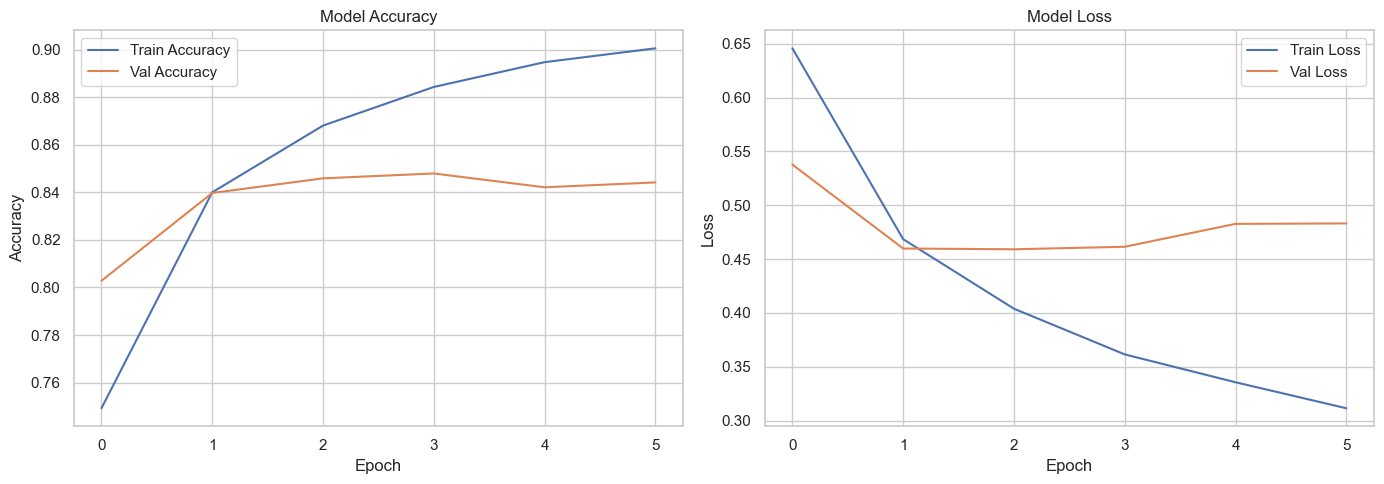

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Akurasi
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Plot Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


**7. Evaluation Model**

In [ ]:
# Evaluate
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]

# Predict (argmax to get class index)
y_pred_test_dl = model.predict(X_test)
y_pred_test_dl = np.argmax(y_pred_test_dl, axis=1)
y_true_test_dl = np.argmax(y_test, axis=1)

# Classification Report
report_dl = classification_report(y_true_test_dl, y_pred_test_dl, output_dict=True)
precision_dl = report_dl['weighted avg']['precision']
recall_dl = report_dl['weighted avg']['recall']
f1_dl = report_dl['weighted avg']['f1-score']

# Summary DataFrame
df_lstm_summary = pd.DataFrame([{
    'model': 'LSTM',
    'accuracy': round(train_acc * 100, 2),
    'test_accuracy': round(test_acc * 100, 2),
    'precision': round(precision_dl * 100, 2),
    'recall': round(recall_dl * 100, 2),
    'f1_score': round(f1_dl * 100, 2)
}])

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step


c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\tugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
df_lstm_summary

,model,accuracy,test_accuracy,precision,recall,f1_score
0,LSTM,88.77,84.59,80.2,84.59,82.28


**8. Save Model**

In [ ]:
model.save('Model_DL/Model85.h5')

## Model Evaluation (All)

In [ ]:
df_modelevaluation = pd.concat([final_df, df_lstm_summary], ignore_index=True)

In [ ]:
df_modelevaluation

,model,accuracy,test_accuracy,precision,recall,f1_score
0,Logistic Regression,87.28,85.13,83.33,85.13,82.81
1,SVM,87.25,85.20,80.66,85.20,82.84
2,Naive Bayes,86.15,85.27,81.09,85.27,82.99
3,LSTM,88.77,84.59,80.20,84.59,82.28


C:\Users\tugas\AppData\Local\Temp\ipykernel_19060\4213910405.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\tugas\AppData\Local\Temp\ipykernel_19060\4213910405.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\tugas\AppData\Local\Temp\ipykernel_19060\4213910405.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\tugas\AppData\Local\Temp\ipykernel_19060\4213910405.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



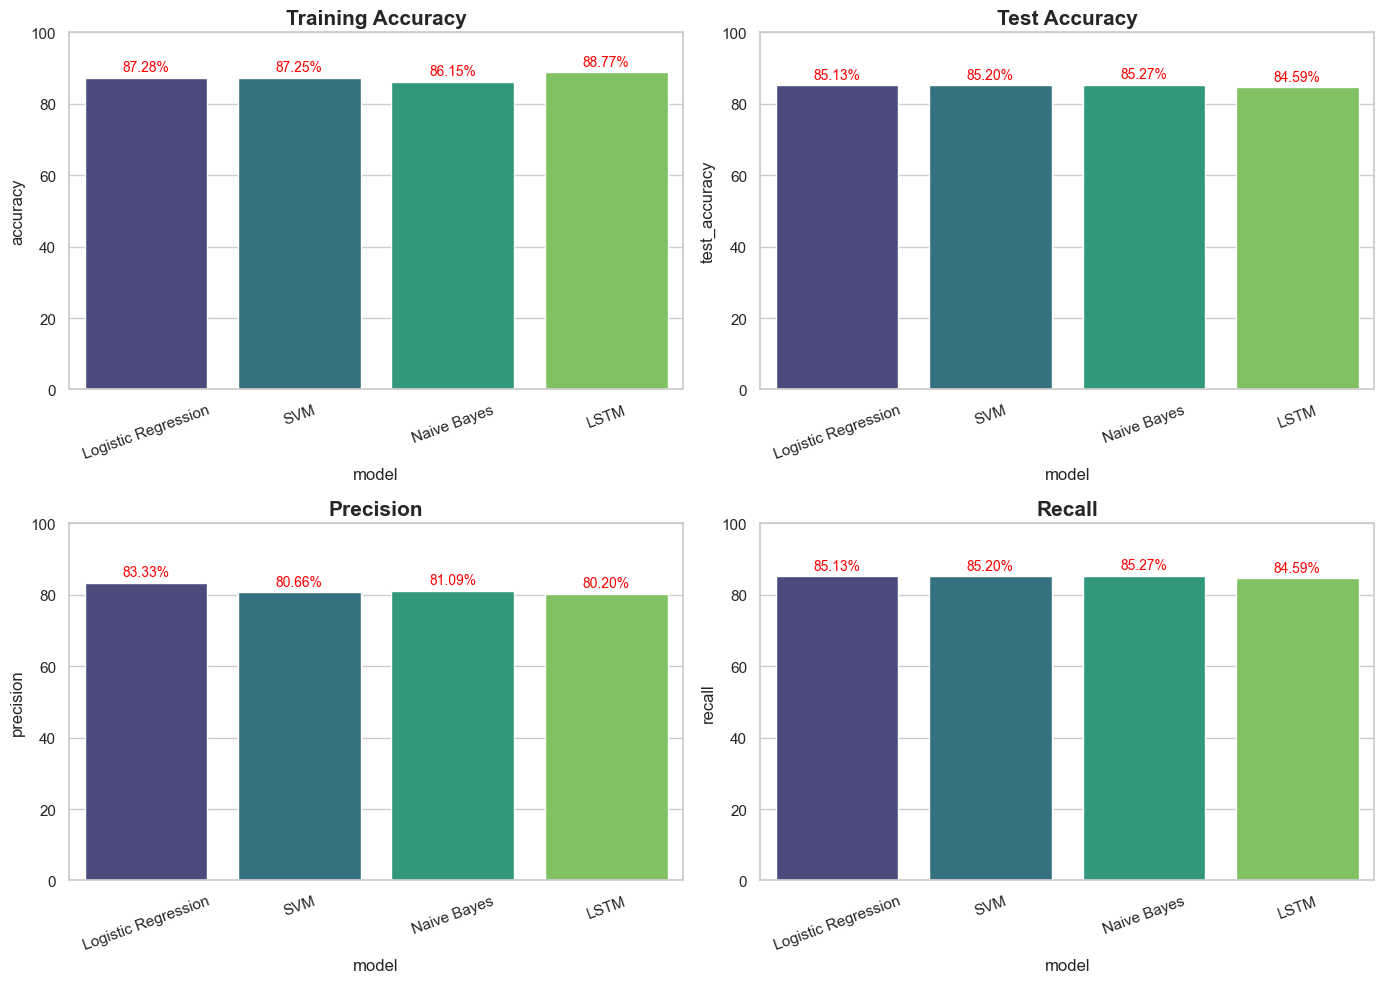

In [ ]:
plt.figure(figsize=(14, 10))

# Subplot 2x2
metrics = ['accuracy', 'test_accuracy', 'precision', 'recall']
titles = ['Training Accuracy', 'Test Accuracy', 'Precision', 'Recall']

for i, metric in enumerate(metrics, 1):
    ax = plt.subplot(2, 2, i)
    sns.barplot(x='model', y=metric, data=df_modelevaluation, palette='viridis', ax=ax)
    ax.set_title(titles[i - 1], weight='bold', fontsize=15)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    
    # Tambahkan nilai di atas bar
    for p in ax.patches:
        value = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, value + 1,
                f'{value:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='normal', color='red')

plt.tight_layout()
plt.show()


## Conclusion Model Evaluation

Dari seluruh pemodelan yang telah dilakukan, diperoleh hasil **akurasi pengujian (test accuracy)** sebagai berikut:

| Model                | Test Accuracy (%) |
|---------------------|-------------------|
| Naive Bayes         | 85.27             |
| SVM                 | 85.20             |
| Logistic Regression | 85.13             |
| LSTM                | 84.59             |

Model dengan performa terbaik diperoleh dari **algoritma machine learning Naive Bayes** yang menggunakan ekstraksi fitur **TF-IDF** dan pembagian data **80:20** untuk train-test split. Model ini diikuti secara berurutan oleh **SVM**, **Logistic Regression**, dan terakhir **LSTM** dari pendekatan deep learning.

Walaupun begitu, hasil akurasi yang diperoleh secara umum masih berada di kisaran **85%**, yang bisa dibilang belum maksimal. Kemungkinan besar ini terjadi karena **model masih kesulitan memahami data secara optimal**, yang diasumsikan disebabkan oleh proses **text preprocessing** yang belum maksimal—khususnya di bagian **slang word handling** dan **stemming**. Masih banyak ditemukan kata-kata yang rancu dan tidak dimengerti oleh model.

###  Evaluasi & Rekomendasi Ke Depan:
- Lakukan **analisis kata (slang word)** menggunakan **WordCloud** atau visualisasi lainnya.
- Tingkatkan proses **text cleaning & preprocessing**, seperti normalisasi kata, stopword removal, dan stemming.
- Terapkan **fine-tuning** pada model yang sudah dilatih (khususnya deep learning).
- Eksplorasi model berbasis **pretrained language model** seperti **BERT** atau **IndoBERT** untuk hasil yang lebih akurat.



# Conclusion

Hasil analisis sentimen terhadap sekitar **14.000** ulasan pengguna aplikasi **GoPay** menunjukkan distribusi sentimen sebagai berikut:

- **Sentimen Positif**: 8.813 ulasan  
  Mayoritas pengguna merasa puas dengan layanan aplikasi, menyatakan bahwa aplikasi mudah digunakan, bermanfaat, dan memiliki antarmuka yang baik.

- **Sentimen Negatif**: 5.075 ulasan  
  Keluhan umum berkaitan dengan fitur saldo, transfer, dan layanan pinjaman, seperti keterlambatan proses, error pada sistem, serta ketidakpuasan terhadap respons layanan pelanggan.

- **Sentimen Netral**: 738 ulasan  
  Sebagian besar ulasan ini, meskipun diklasifikasikan sebagai netral, mengandung nada negatif secara implisit.

Model klasifikasi dibangun menggunakan beberapa pendekatan, yaitu **Naive Bayes**, **Support Vector Machine**, **Logistic Regression**, dan **LSTM**, dengan fitur representasi teks berupa **TF-IDF** dan **word embedding**.

Perbandingan performa akurasi model pada data pengujian ditunjukkan dalam tabel berikut:

| Model                    | Akurasi (%) |
|--------------------------|-------------|
| Naive Bayes              | 85,27       |
| Support Vector Machine   | 85,20       |
| Logistic Regression      | 85,13       |
| Long Short-Term Memory   | 84,59       |

Dari hasil tersebut, dapat disimpulkan bahwa algoritma **Naive Bayes** merupakan metode yang paling efektif dalam konteks data ini, walaupun selisih performanya relatif kecil dengan model lainnya. Pendekatan deep learning (LSTM) belum menunjukkan keunggulan signifikan, kemungkinan disebabkan oleh keterbatasan dalam jumlah data dan parameter model.

---

## Saran

Penelitian ini memberikan beberapa rekomendasi sebagai bahan pertimbangan untuk penelitian selanjutnya maupun pengembangan sistem:

1. **Optimalisasi tahap pra-pemrosesan teks**, khususnya pada normalisasi kosakata tidak baku dan stemming yang masih belum sempurna.

2. **Evaluasi ulang kategori sentimen netral**, karena ditemukan adanya bias negatif dalam sejumlah ulasan yang dikategorikan netral.

3. **Eksplorasi model pretrained seperti IndoBERT**, yang telah dilatih menggunakan korpus Bahasa Indonesia dalam skala besar, guna menangkap konteks linguistik secara lebih akurat.

4. **Pengembangan sistem monitoring sentimen secara real-time**, untuk membantu pengambilan keputusan oleh tim produk dan layanan pelanggan berdasarkan keluhan atau masukan pengguna yang terkini.

**- Requirments.txt**

In [ ]:
import os
import subprocess

# Nama folder tujuan (pastikan folder 'code' sudah ada atau bisa buat dulu)
folder_name = "requirements"
os.makedirs(folder_name, exist_ok=True)

# Path file requirements.txt
file_path = os.path.join(folder_name, "requirements.txt")

# Jalankan pip freeze dan simpan ke file
with open(file_path, "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)

print(f"✅ requirements.txt berhasil dibuat di folder: {file_path}")


✅ requirements.txt berhasil dibuat di folder: requirements\requirements.txt
